In [1]:
from get_file_matches import get_tif_file_matches, get_als_tif_matches
from preprocess_and_stack import stack_and_save
from load_train_eval import load_data, train_and_evaluate, visualize_prediction, evaluate_predictions

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
import rasterio
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import os

In [2]:
def build_unet(input_shape):
    inputs = layers.Input(input_shape)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    return models.Model(inputs, outputs)

In [3]:
als_folder = "data/Tschernitz/als"
dop_folder = "data/Tschernitz/dop"
output_base_dir = "data/Tschernitz/output"

#stack_and_save(als_folder, dop_folder, output_base_dir) --stacks dop images with chm and slope maps

In [4]:
root_dir = "data/Tschernitz"
folder1 = "dop"
folder2 = "ground_truth_masks/forest_masks"

# Match stacked TIF and ground truth mask
matches = get_tif_file_matches(root_dir, folder1, folder2, contains2="merged")

# Load Data and Train
X, Y = load_data(matches)

# Normalize inputs and binarize ground truth masks
X = X / 255.0
Y = (Y > 0).astype(np.float32)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


Folder1 Path: data/Tschernitz\dop
Folder2 Path: data/Tschernitz\ground_truth_masks/forest_masks


Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 867ms/step - accuracy: 0.4211 - loss: 0.6998 - val_accuracy: 0.6818 - val_loss: 0.6868
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 827ms/step - accuracy: 0.5774 - loss: 0.6906 - val_accuracy: 0.7020 - val_loss: 0.6789
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 793ms/step - accuracy: 0.7105 - loss: 0.6771 - val_accuracy: 0.7480 - val_loss: 0.6494
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 858ms/step - accuracy: 0.6606 - loss: 0.6646 - val_accuracy: 0.7276 - val_loss: 0.5978
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 864ms/step - accuracy: 0.6707 - loss: 0.6217 - val_accuracy: 0.7520 - val_loss: 0.5450
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 848ms/step - accuracy: 0.6840 - loss: 0.8266 - val_accuracy: 0.4712 - val_loss: 0.6966
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 803ms/step - accuracy: 0.4849 - loss: 0.6927 - val_accuracy: 0.6518 - val_loss: 0.6429
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 796ms/step - accuracy: 0.6865 - loss: 0.6474 - val_accuracy: 0.7514 - val_loss:

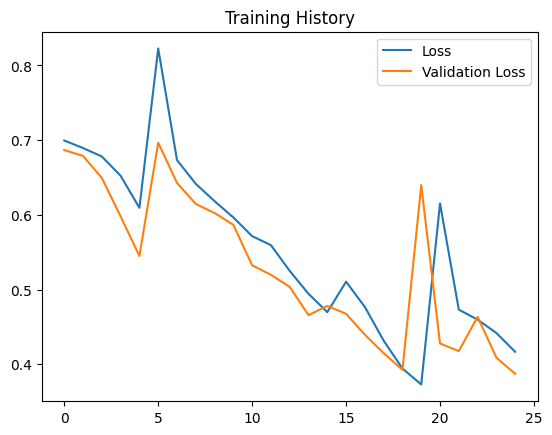

Evaluating model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


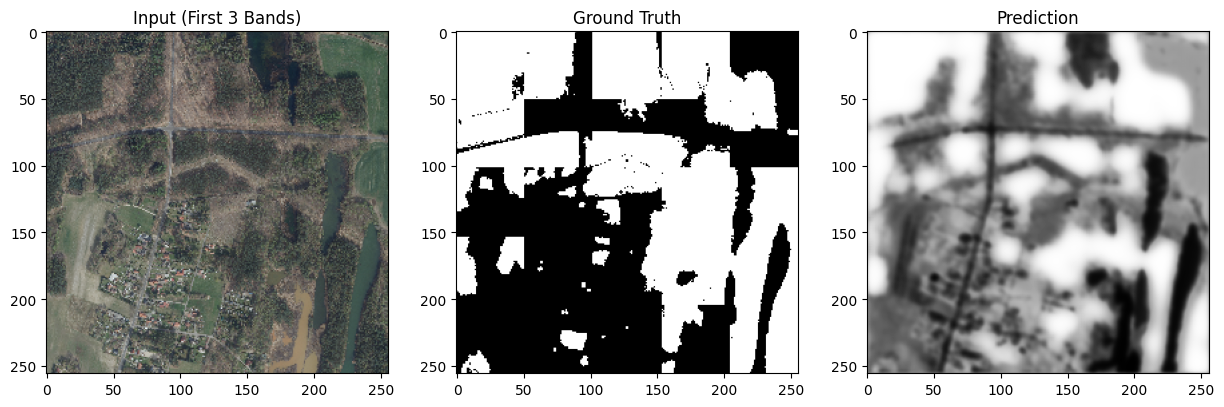

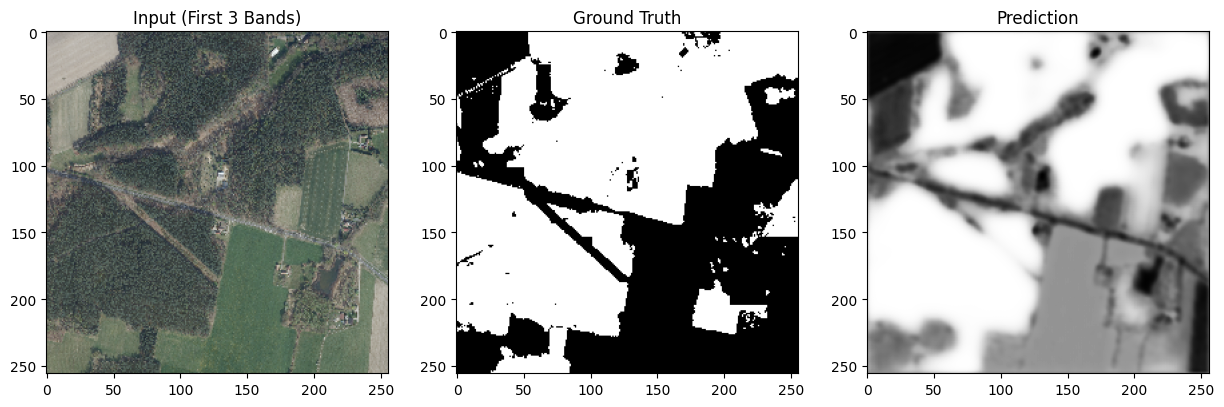

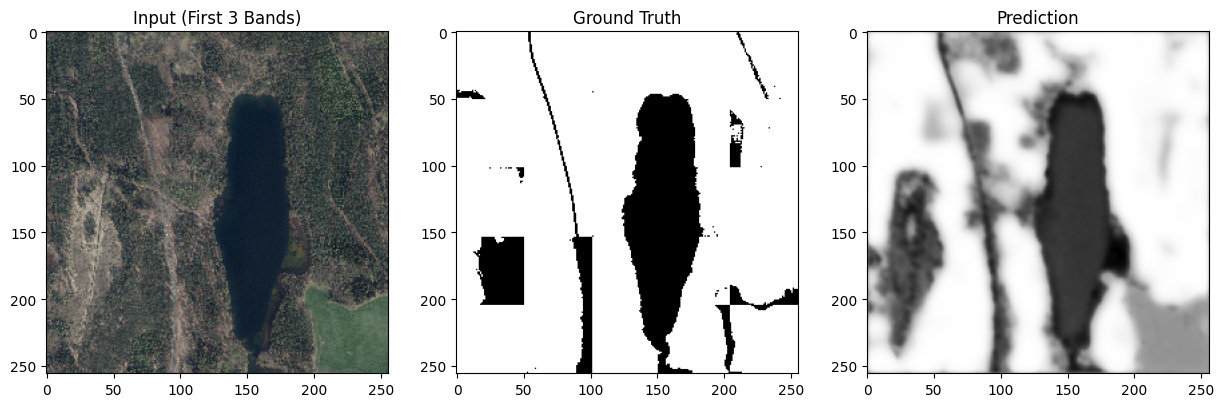

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step

==== Model Evaluation Metrics ====
IoU: 0.7296
Dice: 0.8375
Accuracy: 0.7984
Precision: 0.8085
Recall: 0.8785


In [5]:
# Train U-Net on full resolution
unet_results_full_dop = train_and_evaluate(X_train, Y_train, X_val, Y_val, build_unet, batch_size=4, epochs=25)

In [6]:
root_dir = "data/Tschernitz"
folder1 = "output"
folder2 = "ground_truth_masks/forest_masks"

# Match stacked TIF and ground truth mask
matches = get_tif_file_matches(root_dir, folder1, folder2, contains1='final_input',contains2="merged")
X, Y = load_data(matches)

# Normalize inputs and binarize ground truth masks
X = X / 255.0
Y = (Y > 0).astype(np.float32)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


Folder1 Path: data/Tschernitz\output
Folder2 Path: data/Tschernitz\ground_truth_masks/forest_masks


Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 862ms/step - accuracy: 0.5273 - loss: 0.7015 - val_accuracy: 0.5783 - val_loss: 0.6890
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 811ms/step - accuracy: 0.6801 - loss: 0.6851 - val_accuracy: 0.7711 - val_loss: 0.6675
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 821ms/step - accuracy: 0.7925 - loss: 0.6574 - val_accuracy: 0.7618 - val_loss: 0.6002
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 835ms/step - accuracy: 0.7705 - loss: 0.5805 - val_accuracy: 0.7933 - val_loss: 0.4899
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 815ms/step - accuracy: 0.7740 - loss: 0.4980 - val_accuracy: 0.8149 - val_loss: 0.4255
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 803ms/step - accuracy: 0.7985 - loss: 0.4952 - val_accuracy: 0.8560 - val_loss: 0.3409
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 814ms/step - accuracy: 0.8511 - loss: 0.3818 - val_accuracy: 0.8675 - val_loss: 0.3879
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 805ms/step - accuracy: 0.8490 - loss: 0.4074 - val_accuracy: 0.8024 - val_loss:

Evaluating model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


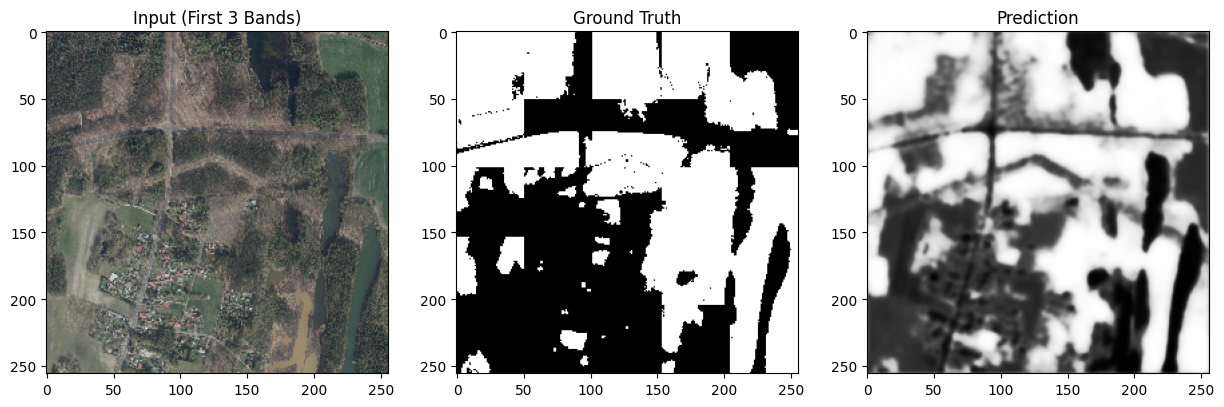

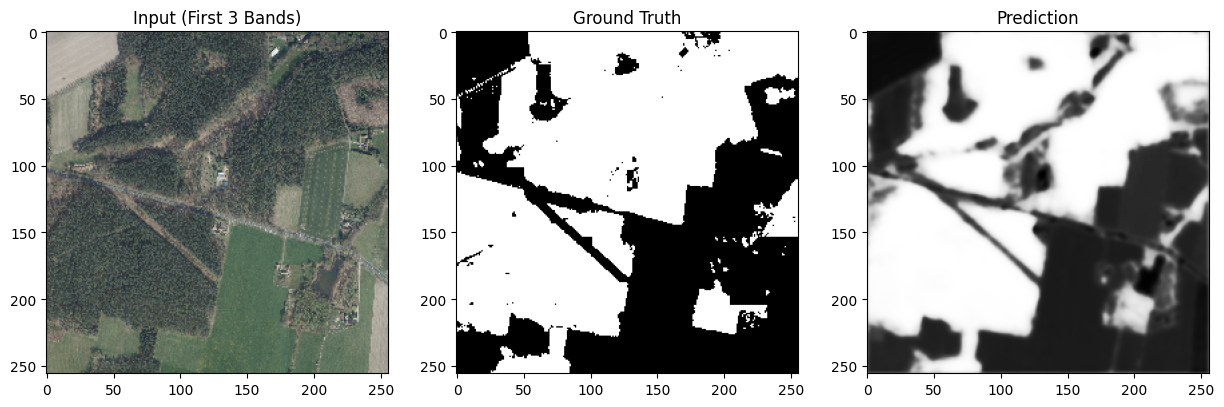

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step

==== Model Evaluation Metrics ====
IoU: 0.8091
Dice: 0.8910
Accuracy: 0.8735
Precision: 0.9120
Recall: 0.8722


In [7]:
# Train U-Net on full resolution
unet_results_full_final_input = train_and_evaluate(X_train, Y_train, X_val, Y_val, build_unet, batch_size=4, epochs=25)

Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4362 - loss: 0.6974 - val_accuracy: 0.7383 - val_loss: 0.6837
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6498 - loss: 0.6975 - val_accuracy: 0.6190 - val_loss: 0.6816
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5700 - loss: 0.6890 - val_accuracy: 0.6903 - val_loss: 0.6810
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7001 - loss: 0.6807 - val_accuracy: 0.7575 - val_loss: 0.6707
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7435 - loss: 0.6707 - val_accuracy: 0.7639 - val_loss: 0.6543
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7616 - loss: 0.6524 - val_accuracy: 0.7559 - val_loss: 0.6314
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 4s/step - accuracy: 0.7340 - loss: 0.6297 - val_accuracy: 0.7797 - val_loss: 0.5840
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7344 - loss: 0.6011 - val_accuracy: 0.7677 - val_loss: 0.5464
Epoch 9/25
2/2 ━

Evaluating model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


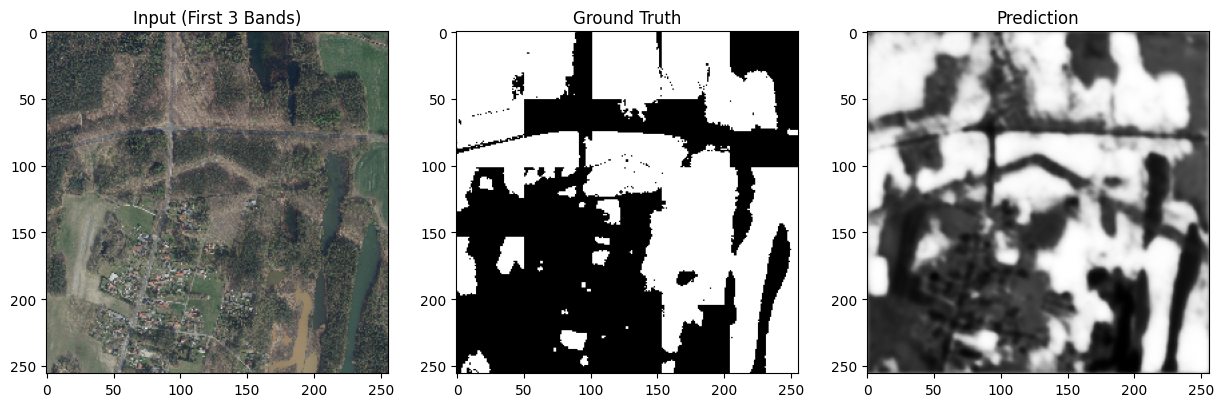

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step

==== Model Evaluation Metrics ====
IoU: 0.7868
Dice: 0.8775
Accuracy: 0.8611
Precision: 0.9236
Recall: 0.8361


In [8]:
unet_results_full_final_input = train_and_evaluate(X_train, Y_train, X_val, Y_val, build_unet, batch_size=8, epochs=25, learning_rate=1e-3)

In [9]:
from augmentation_pipeline import augment_dataset, plot_original_and_augmented_versions


Applying Augmentation Configuration 1/4: {'RandomRotate90': 0.5, 'HorizontalFlip': 0.5}
Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 846ms/step - accuracy: 0.4368 - loss: 0.6939 - val_accuracy: 0.7866 - val_loss: 0.6661
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 863ms/step - accuracy: 0.7068 - loss: 0.6558 - val_accuracy: 0.7948 - val_loss: 0.5259
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 844ms/step - accuracy: 0.7355 - loss: 0.5654 - val_accuracy: 0.7666 - val_loss: 0.5115
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 833ms/step - accuracy: 0.7752 - loss: 0.4929 - val_accuracy: 0.8218 - val_loss: 0.4032
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 811ms/step - accuracy: 0.8355 - loss: 0.3993 - val_accuracy: 0.8489 - val_loss: 0.3499
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 837ms/step - accuracy: 0.8437 - loss: 0.3733 - val_accuracy: 0.8662 - val_loss: 0.3437
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 866ms/step - accuracy: 0.8574 - loss: 0.3489 - val_accuracy: 0.8692 - val_loss: 0.3192
Epoch 8/25
8/8 ━━━━━━━━━━━━━━

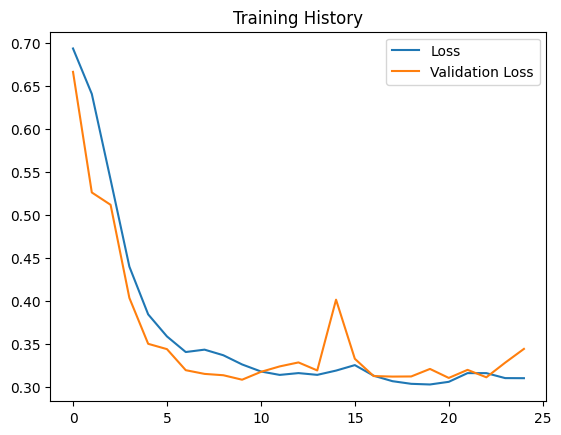

Evaluating model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step

==== Model Evaluation Metrics ====
IoU: 0.8235
Dice: 0.8990
Accuracy: 0.8744
Precision: 0.8713
Recall: 0.9347

Applying Augmentation Configuration 2/4: {'ShiftScaleRotate': {'shift_limit': 0.01, 'scale_limit': 0.05, 'rotate_limit': 15, 'p': 0.5}}
Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 821ms/step - accuracy: 0.5440 - loss: 0.7031 - val_accuracy: 0.6682 - val_loss: 0.6918
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 839ms/step - accuracy: 0.6144 - loss: 0.6909 - val_accuracy: 0.7715 - val_loss: 0.6848
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 828ms/step - accuracy: 0.7618 - loss: 0.6792 - val_accuracy: 0.7908 - val_loss: 0.6380
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 852ms/step - accuracy: 0.7818 - loss: 0.6182 - val_accuracy: 0.6190 - val_loss: 0.7728
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 842ms/step - accuracy: 0.5721 - loss: 0.7837 - val_accuracy: 0.7282 - val_loss: 0.6132
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 853ms/step - accuracy: 0

Evaluating model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step

==== Model Evaluation Metrics ====
IoU: 0.8193
Dice: 0.8975
Accuracy: 0.8764
Precision: 0.8917
Recall: 0.9070

Applying Augmentation Configuration 3/4: {'RandomBrightnessContrast': {'brightness_limit': 0.1, 'contrast_limit': 0.1, 'p': 0.5}}
Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 862ms/step - accuracy: 0.5237 - loss: 0.7308 - val_accuracy: 0.5682 - val_loss: 0.6865
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 813ms/step - accuracy: 0.5267 - loss: 0.6829 - val_accuracy: 0.7271 - val_loss: 0.6684
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 839ms/step - accuracy: 0.7351 - loss: 0.6573 - val_accuracy: 0.7536 - val_loss: 0.6249
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 835ms/step - accuracy: 0.7714 - loss: 0.6175 - val_accuracy: 0.7800 - val_loss: 0.5008
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 823ms/step - accuracy: 0.7423 - loss: 0.5578 - val_accuracy: 0.7667 - val_loss: 0.4900
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 890ms/step - accuracy: 0.7704 

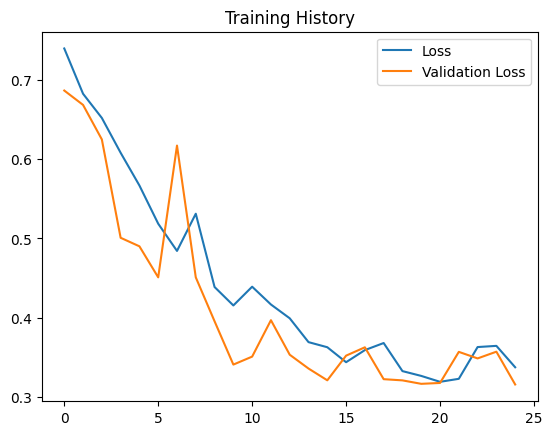

Evaluating model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step

==== Model Evaluation Metrics ====
IoU: 0.8055
Dice: 0.8896
Accuracy: 0.8718
Precision: 0.9147
Recall: 0.8671

Applying Augmentation Configuration 4/4: {'GaussNoise': {'var_limit': (5.0, 25.0), 'p': 0.3}}
Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 815ms/step - accuracy: 0.4343 - loss: 0.6978 - val_accuracy: 0.3895 - val_loss: 0.6912
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 854ms/step - accuracy: 0.5344 - loss: 0.6887 - val_accuracy: 0.7109 - val_loss: 0.6720
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 867ms/step - accuracy: 0.6734 - loss: 0.6694 - val_accuracy: 0.6905 - val_loss: 0.6303
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 820ms/step - accuracy: 0.7119 - loss: 0.6186 - val_accuracy: 0.7510 - val_loss: 0.5506
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 842ms/step - accuracy: 0.7289 - loss: 0.5638 - val_accuracy: 0.7734 - val_loss: 0.5011
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 832ms/step - accuracy: 0.7475 - loss: 0.5345 - val_accuracy: 0.782

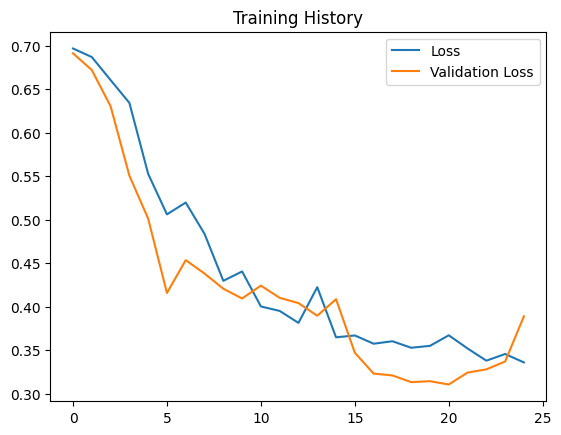

Evaluating model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step

==== Model Evaluation Metrics ====
IoU: 0.7983
Dice: 0.8821
Accuracy: 0.8465
Precision: 0.8364
Recall: 0.9465


In [12]:
augment_configs = [
    {"RandomRotate90": 0.5, "HorizontalFlip": 0.5},
    {"ShiftScaleRotate": {"shift_limit": 0.01, "scale_limit": 0.05, "rotate_limit": 15, "p": 0.5}},
    {"RandomBrightnessContrast": {"brightness_limit": 0.1, "contrast_limit": 0.1, "p": 0.5}},
    {"GaussNoise": {"var_limit": (5.0, 25.0), "p": 0.3}},
]
results = {}
for i, config in enumerate(augment_configs):
    print(f"\nApplying Augmentation Configuration {i+1}/{len(augment_configs)}: {config}")
    X_train_aug, Y_train_aug = augment_dataset(X_train, Y_train, config, num_versions=2)
    results[f"Config_{i+1}"] = train_and_evaluate(X_train_aug, Y_train_aug, X_val, Y_val, build_unet, batch_size=4, epochs=25, visualize=False)


In [14]:
# Plot the first 3 images and their augmented versions
#plot_original_and_augmented_versions(X_train[:3], X_train_aug, num_samples=3, num_versions=5)